# Imports

In [1]:
import progressbar

In [2]:
import sys
import os
import requests
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession

In [3]:
app_name="Case Study 2"

conf = SparkConf().setAppName(app_name)
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

In [4]:
sc.applicationId

'local-1572213019991'

In [5]:
log4jLogger = sc._jvm.org.apache.log4j
LOGGER = log4jLogger.LogManager.getLogger(__name__)
LOGGER.info("pyspark script logger initialized")

# Load data into Spark DataFrame

In [11]:
def get_hdfs_filepath(file_name, on_cloud=True):
    # path to folder containing this code
    prefix = '/data/spark/6_cs2_dataset/'
    if on_cloud:
        bucket  = os.environ['BUCKET']
        file_path = bucket + prefix + file_name
    else:
        file_path = '/Users/val' + prefix + file_name

    return file_path

In [12]:
LOG = get_hdfs_filepath('access.log')
CLEAN_LOG = get_hdfs_filepath('access.clean.log')

In [13]:
print(LOG)

gs://drive3/data/spark/6_cs2_dataset/access.log


In [14]:
from pyspark.sql import Row

row = Row("line")

log_txt_df=sc.textFile(LOG).filter(lambda line: line != '').map(row).toDF()

In [15]:
log_txt_df.take(10)

[Row(line='109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -'),
 Row(line='109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -'),
 Row(line='46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -'),
 Row(line='46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -'),
 Row(line='83.167.113.100 - - [12/Dec/2015:18:31:25 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -'),
 Row(line='83.167.113.100 - - [12/Dec/2015:18:31:25 +010

## Convert strings to columns

In [16]:
import datetime as dt
import dateutil.parser
import pytz

def to_utc_timestamp(string):
    zone_idx = string.find('-') if string.find('-') >= 0 else string.find('+')
    timezone_str = string[zone_idx:]
    date_time_str = string[:zone_idx-1]
    date_time_obj = dt.datetime.strptime(date_time_str, '%d/%b/%Y:%H:%M:%S')
    dt2 = dateutil.parser.parse(str(date_time_obj)+timezone_str)
    return dt2.astimezone(pytz.timezone("UTC"))

converted = to_utc_timestamp('12/Dec/2015:18:25:11 +0200')


In [18]:
from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.types import StringType, IntegerType, TimestampType
from pyspark.sql.functions import udf, expr

udf1 = udf(to_utc_timestamp, TimestampType())

result = log_txt_df.select(
    regexp_extract(col('line'), r'http:\S+', 0).alias('url'),
    regexp_extract(col('line'), r'\d+\.\d+\.\d+\.\d+\s', 0).alias("ip"),
    regexp_extract(col('line'), r'\d{2}.\w{3}.\d{4}:\d{2}:\d{2}:\d{2}\s.\d{4}', 0).alias("datetime"),
    regexp_extract(col('line'), r"(\sGET\s|\sPOST\s|\sPUT\s|\sHEAD\s)", 0).alias("request"), 
    regexp_extract(col('line'), r"\s\S+\sHTTP/\d", 0).alias("path"),   
    regexp_extract(col('line'), r'HTTP/\S+\s\d{3}', 0).alias("response"),                                                                   
    regexp_extract(col('line'), r'\s\d{3}\s\d+\s', 0).alias("bytes") 
 ).select(
    'url', 'ip','datetime', udf1('datetime').alias('utc_timestamp'),
    expr("substring(request, 2, length(request)-2)").alias("request"),# same as str[1:-1]
    expr("substring(path, 2, length(path)-8)").alias("path"),# same as str[1:-7]   
    expr("substring(response, -3, 3)").alias("response").cast(IntegerType()),# same as str[-3:] 
    expr("substring(bytes, 6, length(bytes)-6)").alias("bytes").cast(IntegerType()),# same as str[5:-1]
)
df=result
df.limit(10).toPandas()#.printSchema()

,url,ip,datetime,utc_timestamp,request,path,response,bytes
0,,109.169.248.247,12/Dec/2015:18:25:11 +0100,2015-12-12 12:25:11,GET,/administrator/,200,4263
1,http://almhuette-raith.at/administrator/,109.169.248.247,12/Dec/2015:18:25:11 +0100,2015-12-12 12:25:11,POST,/administrator/index.php,200,4494
2,,46.72.177.4,12/Dec/2015:18:31:08 +0100,2015-12-12 12:31:08,GET,/administrator/,200,4263
3,http://almhuette-raith.at/administrator/,46.72.177.4,12/Dec/2015:18:31:08 +0100,2015-12-12 12:31:08,POST,/administrator/index.php,200,4494
4,,83.167.113.100,12/Dec/2015:18:31:25 +0100,2015-12-12 12:31:25,GET,/administrator/,200,4263
5,http://almhuette-raith.at/administrator/,83.167.113.100,12/Dec/2015:18:31:25 +0100,2015-12-12 12:31:25,POST,/administrator/index.php,200,4494
6,,95.29.198.15,12/Dec/2015:18:32:10 +0100,2015-12-12 12:32:10,GET,/administrator/,200,4263
7,http://almhuette-raith.at/administrator/,95.29.198.15,12/Dec/2015:18:32:11 +0100,2015-12-12 12:32:11,POST,/administrator/index.php,200,4494
8,,109.184.11.34,12/Dec/2015:18:32:56 +0100,2015-12-12 12:32:56,GET,/administrator/,200,4263
9,http://almhuette-raith.at/administrator/,109.184.11.34,12/Dec/2015:18:32:56 +0100,2015-12-12 12:32:56,POST,/administrator/index.php,200,4494


# Find out how many 404 HTTP codes are in access logs

In [19]:
df.filter("response = '404'").count()

227101

# Find out which URLs are broken

In [22]:
broken = df.where('response!=200').groupBy('url').count().orderBy('count', ascending =0)

In [23]:
broken.limit(10).show()

+--------------------+------+
|                 url| count|
+--------------------+------+
|http://www.almhue...|931576|
|http://almhuette-...| 92772|
|                    | 54855|
|http://www.owasp....| 46737|
|http://www.almhue...| 13610|
|http://www.almhue...|  4528|
|http://www.almhue...|  3536|
|http://almhuette-...|  3247|
|http://www.almhue...|  2702|
|      http://site.ru|  2576|
+--------------------+------+



# Verify there are no null columns in the original dataset

In [24]:
# ckeck if null and NaN values are present in our DF
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when( col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,url,ip,datetime,utc_timestamp,request,path,response,bytes
0,0,0,0,0,0,0,0,6341


# Replace null values with constants such as 0

In [21]:
df = df.na.fill(0)

In [22]:
# ckeck if null and NaN values are present in our DF
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when( col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,url,ip,datetime,utc_timestamp,request,path,response,bytes
0,0,0,0,0,0,0,0,0


# Parse timestamp to readable date

In [23]:
df.select('datetime','utc_timestamp').limit(10).toPandas()

,datetime,utc_timestamp
0,12/Dec/2015:18:25:11 +0100,2015-12-12 12:25:11
1,12/Dec/2015:18:25:11 +0100,2015-12-12 12:25:11
2,12/Dec/2015:18:31:08 +0100,2015-12-12 12:31:08
3,12/Dec/2015:18:31:08 +0100,2015-12-12 12:31:08
4,12/Dec/2015:18:31:25 +0100,2015-12-12 12:31:25
5,12/Dec/2015:18:31:25 +0100,2015-12-12 12:31:25
6,12/Dec/2015:18:32:10 +0100,2015-12-12 12:32:10
7,12/Dec/2015:18:32:11 +0100,2015-12-12 12:32:11
8,12/Dec/2015:18:32:56 +0100,2015-12-12 12:32:56
9,12/Dec/2015:18:32:56 +0100,2015-12-12 12:32:56


# Describe which HTTP status values appear in data and how many

In [24]:
stat = df.groupBy('response').count().orderBy('count', ascending = False)

In [25]:

stat.show()
#codes = stat.select('response')

+--------+-------+
|response|  count|
+--------+-------+
|     200|1157832|
|     206| 939929|
|     404| 227101|
|     304|   6330|
|     500|   3252|
|     403|   2222|
|     301|    619|
|     303|    247|
|     401|    153|
|     501|    143|
|     405|     83|
|     406|     53|
|     400|     23|
|     412|     19|
+--------+-------+



# Display as chart the above stat in chart in Zeppelin notebook

In [26]:
pddf = stat.toPandas()
responses = pddf.iloc[:,0].values.astype(str)
counts = pddf.iloc[:,1].values

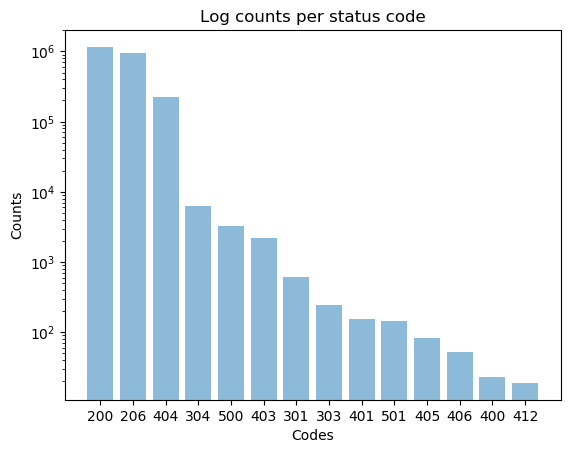

In [30]:
import matplotlib.pyplot as plt
plt.rcdefaults()

import numpy as np

y_pos = np.arange(len(responses))


plt.bar(y_pos, counts, align='center', alpha=0.5, log = True)
plt.xticks(y_pos, responses)
plt.ylabel('Counts')
plt.xlabel('Codes')

plt.title('Log counts per status code')

plt.show()

# How many unique hosts are there in the entire log and their average request

In [29]:
from urllib.parse import urlparse

def get_host(url):
    return urlparse(url).netloc

get_host_udf = udf(get_host, StringType())

hosts = df.select( get_host_udf(df.url).alias('host')).groupBy('host').count().orderBy('count', ascending = 0)
hosts.limit(10).toPandas()


,host,count
0,www.almhuette-raith.at,1207302
1,,588728
2,almhuette-raith.at,408025
3,www.owasp.org,46812
4,www.bing.com,9208
5,www.google.com,6394
6,www.baidu.com,4050
7,yandex.com,2801
8,site.ru,2588
9,cirt.net,2462
